In [1]:
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### Plotting Endmotif

In [2]:
plot_motif_frequency <- function(data_path, outdir, bin_size=10, range = c(10, 3000)) {

  #Get the samplename: basename and remove the "".sort.bed"
  samplename <- gsub(".sort.bed", "", basename(data_path))

  # Read the data
  data <- read.table(data_path, header = FALSE, sep = "\t")

  #Remove the unmapped reads: nothing in the V8 column
  data <- data[!data$V8 == "",]
  
  # Select the essential columns
  data <- data[, c(6, 8, 9)]

  # Create V10 column: first character of V8
  data$V10 <- substr(data$V8, 1, 1)
  # Create V11 column: first character of V9
  data$V11 <- substr(data$V9, 1, 1)

  # Name the columns
  colnames(data) <- c("len", "four_nu_end1", "four_nu_end2", "one_nu_end1", "one_nu_end2")
  #head(data)

  # Remove the record with length out of the range
  data_filtered <- data %>%
    filter(len >= range[1] & len <= range[2])

  # Create bins of size 10
  data_filtered <- data_filtered %>%
    mutate(len_bin = cut(len, breaks = seq(10, 3000, by = bin_size), right = FALSE)) %>%
    # Sort by len: ascending
    arrange(len)

  # Calculate the frequency of each one_nu_end1 value across different len bins
  data_plot <- data_filtered %>%
    group_by(len_bin, one_nu_end1) %>%
    summarise(n = n()) %>%
    mutate(freq = n * 100 / sum(n)) %>%
    mutate(len = as.numeric(len_bin)) %>%
    mutate(len = len * bin_size)


  # Create the line plot: x-axis is len_bin, y-axis is freq, color is one_nu_end1
  motif_plot = ggplot(data_plot, aes(x = len, y = freq, color = one_nu_end1)) +
                geom_line(size = 1) +
                labs(title = paste0("Frequency of first nucleotide at 5' \nacross different length: ",samplename),
                    x = "Read length (bps)",
                    y = "Frequency (%)",
                    color = "one_nu_end1") +
                theme_minimal()
  
  print(motif_plot)
  
  #Save the file
  outpath <- paste0(outdir, "/", samplename, ".endmotif.png")
  ggsave(outpath, plot = motif_plot, width = 10, height = 6, dpi = 300)
  
}

In [ ]:
motif_dir = "/mnt/NAS_PROJECT/vol_Phucteam/CONGNGUYEN/pipeline/NANOPORE_DATA/Basecalling_result/basecalling_result_Nanopore07/2B.Dorado_demux_2ends/output/extract"
outdir = "/mnt/NAS_PROJECT/vol_Phucteam/CONGNGUYEN/pipeline/NANOPORE_DATA/Basecalling_result/basecalling_result_Nanopore07/2B.Dorado_demux_2ends/output/extract"
#For file in /mnt/NAS_PROJECT/vol_Phucteam/CONGNGUYEN/pipeline/NANOPORE_DATA/Basecalling_result/basecalling_result_Nanopore07/2B.Dorado_demux_2ends/output/extract
for (file in list.files(motif_dir, pattern="*.bed", full.names=TRUE)){

  print(paste("Processing file", file))
  plot_motif_frequency(file,outdir)
  
}

## Calculate the short-long ratio

[1] "SQK-NBD114-24_barcode04"
[1] "SQK-NBD114-24_barcode05"
[1] "SQK-NBD114-24_barcode06"
[1] "SQK-NBD114-24_barcode07"
[1] "SQK-NBD114-24_barcode08"
[1] "SQK-NBD114-24_barcode09"
[1] "SQK-NBD114-24_barcode10"
[1] "SQK-NBD114-24_barcode11"
[1] "SQK-NBD114-24_barcode12"
[1] "SQK-NBD114-24_barcode13"
[1] "SQK-NBD114-24_barcode14"
[1] "SQK-NBD114-24_barcode15"


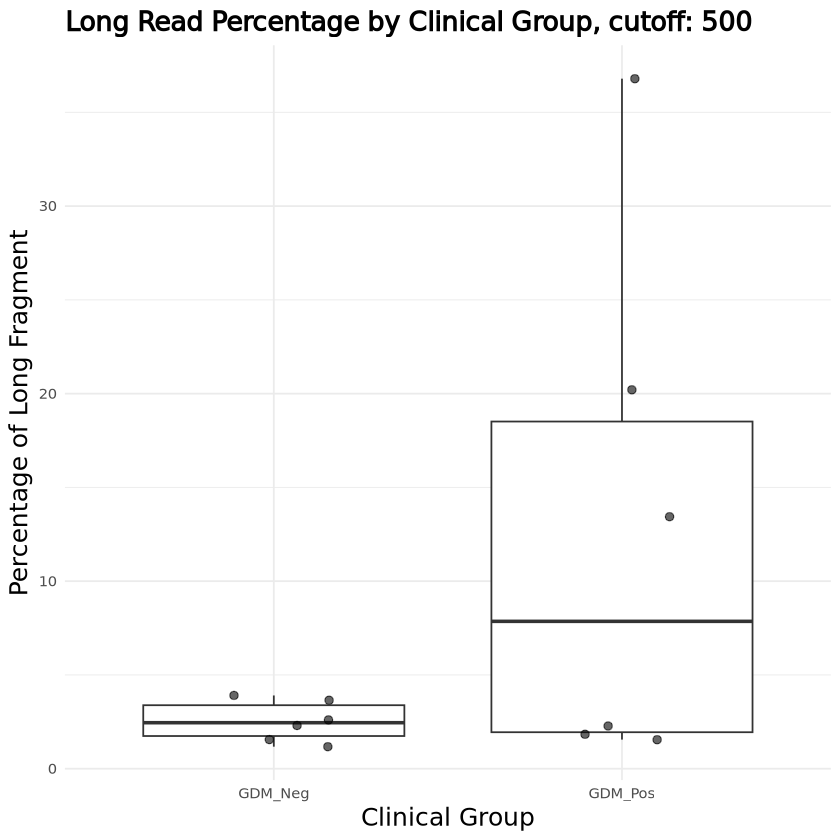

[1] "SQK-NBD114-24_barcode04"
[1] "SQK-NBD114-24_barcode05"
[1] "SQK-NBD114-24_barcode06"
[1] "SQK-NBD114-24_barcode07"
[1] "SQK-NBD114-24_barcode08"
[1] "SQK-NBD114-24_barcode09"
[1] "SQK-NBD114-24_barcode10"
[1] "SQK-NBD114-24_barcode11"
[1] "SQK-NBD114-24_barcode12"
[1] "SQK-NBD114-24_barcode13"
[1] "SQK-NBD114-24_barcode14"
[1] "SQK-NBD114-24_barcode15"


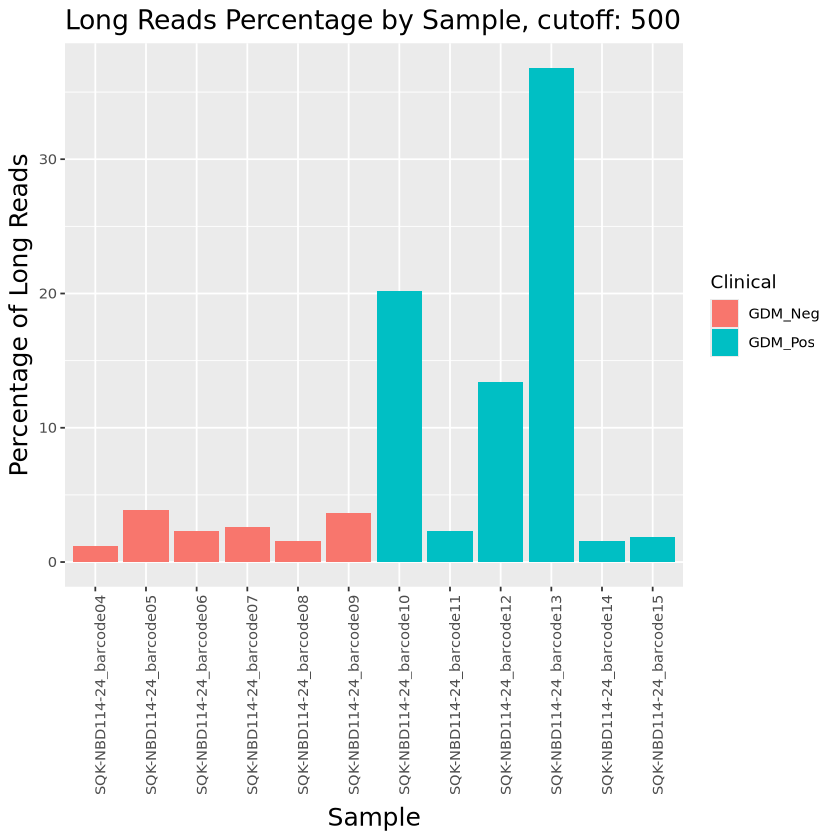

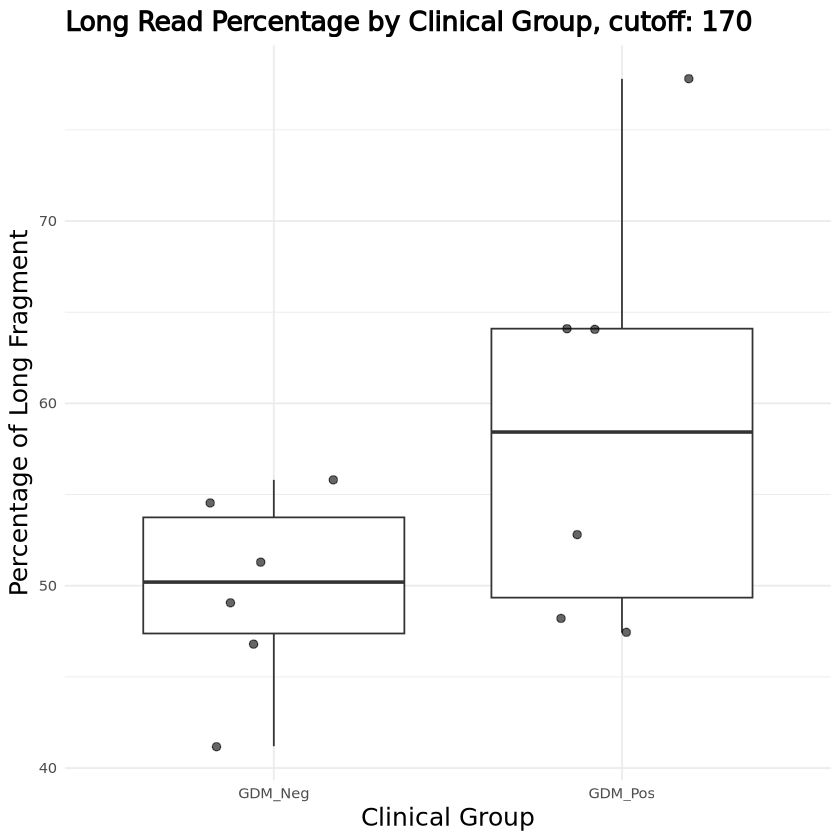

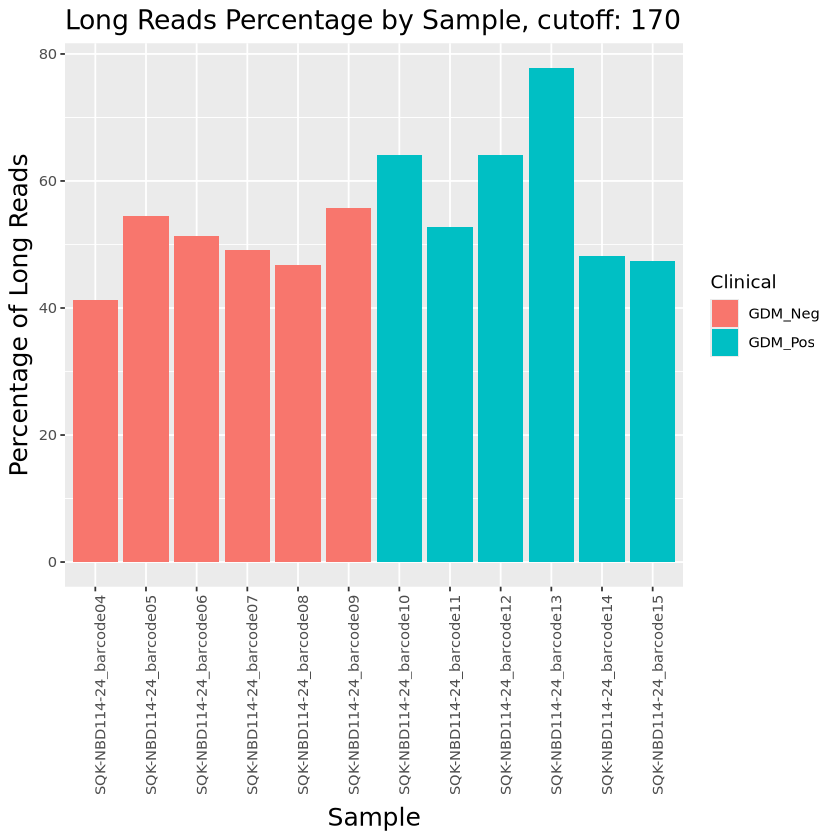

In [35]:
data_path = "/mnt/NAS_PROJECT/vol_Phucteam/CONGNGUYEN/pipeline/NANOPORE_DATA/Basecalling_result/basecalling_result_Nanopore07/2B.Dorado_demux_2ends/output/extract"

# Create the dataframe
clinical_data <- data.frame(
  Sample = c("SQK-NBD114-24_barcode04", "SQK-NBD114-24_barcode05", "SQK-NBD114-24_barcode06", 
             "SQK-NBD114-24_barcode07", "SQK-NBD114-24_barcode08", "SQK-NBD114-24_barcode09", 
             "SQK-NBD114-24_barcode10", "SQK-NBD114-24_barcode11", "SQK-NBD114-24_barcode12", 
             "SQK-NBD114-24_barcode13", "SQK-NBD114-24_barcode14", "SQK-NBD114-24_barcode15"),
  Clinical = c("GDM_Neg", "GDM_Neg", "GDM_Neg", "GDM_Neg", "GDM_Neg", "GDM_Neg", 
               "GDM_Pos", "GDM_Pos", "GDM_Pos", "GDM_Pos", "GDM_Pos", "GDM_Pos"),
  stringsAsFactors = FALSE
)

#Create a function to calculate the percentage of long reads
plot_long_ratio <- function(data_path, cut_off,clinical_data) {
    #List all the file in the directory: data_path
    data_files <- list.files(data_path, pattern = ".bed", full.names = TRUE)

    #Create empty data frame: with 3 columns (Sample and perc_long)
    perc_long_df <- data.frame(Sample = character(), perc_long = numeric(), stringsAsFactors = FALSE)

    #For each file in data_files
    for (file in data_files) {
        #Get the samplename: basename and remove the ".sort.bed"
        samplename <- gsub(".sort.bed", "", basename(file))
        print(samplename)

        #Reads the file
        data <- read.table(file, header = FALSE, sep = "\t")

        #Check if the number of row < 1000 --> skip
        if (nrow(data) < 1000) {
            next
        }

        #Remove the record with nothing in the V8 column
        data <- data[!data$V8 == "",]

        #Count the number of short records: V6 < cut_off
        short_reads <- sum(data$V6 < cut_off)
        #Count the number of long records: V6 >= cut_off
        long_reads <- sum(data$V6 >= cut_off)

        #short_ratio <- short_reads*100 / total
        short <- short_reads*100 / (short_reads + long_reads)

        #long_ratio <- long_reads*100 / total
        long <- long_reads*100 / (short_reads + long_reads)

        #Add the sample name and the percentage of long reads to the data frame
        perc_long_df <- rbind(perc_long_df, data.frame(Sample = samplename, perc_long = long))
    }

    #Merge perc_long_df with clinical_data
    merged_df <- merge(perc_long_df, clinical_data, by = "Sample")

    #Render boxplot: x-axis is Clinical, y-axis is perc_long
    long_ratio_plot_boxplot =  ggplot(merged_df, aes(x = Clinical, y = perc_long)) +
                            geom_boxplot() +
                            geom_jitter(width = 0.2, size = 2, alpha = 0.6) +  # Add jittered data points
                            labs(title = paste0("Long Read Percentage by Clinical Group, cutoff: ",cut_off),
                                x = "Clinical Group",
                                y = "Percentage of Long Fragment") +
                            theme_minimal() +
                            theme(
                                plot.title = element_text(size = 16, face = "bold"),  # Adjust title size
                                axis.title.x = element_text(size = 15),  # Adjust x-axis label size
                                axis.title.y = element_text(size = 15)   # Adjust y-axis label size
                            )
    
    print(long_ratio_plot_boxplot)

    # Create the barplot
    long_ratio_plot_barplot = ggplot(merged_df, aes(x = Sample, y = perc_long, fill = Clinical)) +
                                geom_bar(stat = "identity", position = "dodge") +
                                labs(title = paste0("Long Reads Percentage by Sample, cutoff: ", cut_off),
                                    x = "Sample",
                                    y = "Percentage of Long Reads") +
                                theme(axis.text.x = element_text(angle = 90, hjust = 1),
                                        axis.title.x = element_text(size = 15),  # Adjust x-axis label size
                                        axis.title.y = element_text(size = 15),  # Adjust y-axis label size
                                        plot.title = element_text(size = 16))    # Adjust title size

    print(long_ratio_plot_barplot)


}

plot_long_ratio(data_path,500,clinical_data)
plot_long_ratio(data_path,170,clinical_data)